In [21]:
#!pip install ydata_profiling
#!pip install pycaret

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import constants
from wordcloud import WordCloud
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier,XGBRegressor
import os
import joblib
import ydata_profiling

plt.style.use("fivethirtyeight")
color_pal = sns.color_palette()

In [23]:
NDP = '/kaggle/input/emotions-dataset-for-nlp/train.txt'
TDP = '/kaggle/input/emotions-dataset-for-nlp/test.txt'
VDP = '/kaggle/input/emotions-dataset-for-nlp/val.txt'

In [24]:
train = pd.DataFrame(columns=['sentence', 'label'])
test = pd.DataFrame(columns=['sentence', 'label'])
val = pd.DataFrame(columns=['sentence', 'label'])

with open(NDP, 'r') as file:
    for _, line in enumerate(file):
        train = pd.concat([
            pd.DataFrame(
                [line.replace('\n', '').split(';')], columns=train.columns
            ),
            train
        ], ignore_index=True)

with open(TDP, 'r') as file:
    for _, line in enumerate(file):
        test = pd.concat([
            pd.DataFrame(
                [line.replace('\n', '').split(';')], columns=test.columns
            ),
            test
        ], ignore_index=True)

with open(VDP, 'r') as file:
    for _, line in enumerate(file):
        val = pd.concat([
            pd.DataFrame(
                [line.replace('\n', '').split(';')], columns=val.columns
            ),
            val
        ], ignore_index=True)

train = train.sample(frac=1, random_state=42)

ns = train['sentence']
ts = test['sentence']
vs = test['sentence']

nl = train['label'].replace(
    to_replace=['sadness', 'surprise', 'fear', 'anger', 'joy', 'love'], 
    value=[0, 1, 2, 3, 4, 5]
)
tl = test['label'].replace(
    to_replace=['sadness', 'surprise', 'fear', 'anger', 'joy', 'love'], 
    value=[0, 1, 2, 3, 4, 5]
)
vl = test['label'].replace(
    to_replace=['sadness', 'surprise', 'fear', 'anger', 'joy', 'love'], 
    value=[0, 1, 2, 3, 4, 5]
)
print(f'Length of Training Set: { len(train) }')
print(f'Length of Test Set: { len(test) }')
print(f'Length of Val Set: { len(val) }')

print('')

print(f'Number of Labels: { len(train["label"].unique()) }')
print('Possible Labels:')
for label in train['label'].unique():
    print(f'    { label }')
    print(f'        Count: { len(train[train["label"] == label]) }')
    print(f'        % of Total: { len(train[train["label"] == label]) / len(train) * 100.}')

Length of Training Set: 16000
Length of Test Set: 2000
Length of Val Set: 2000

Number of Labels: 6
Possible Labels:
    sadness
        Count: 4666
        % of Total: 29.1625
    surprise
        Count: 572
        % of Total: 3.5749999999999997
    fear
        Count: 1937
        % of Total: 12.106250000000001
    anger
        Count: 2159
        % of Total: 13.493749999999999
    joy
        Count: 5362
        % of Total: 33.5125
    love
        Count: 1304
        % of Total: 8.15


In [35]:
import random
def view_random_sentence():
    row_num = random.randint(0, len(train) - 1)

    print(f'emotion: { train.iloc[row_num]["label"] }')
    print(f'sentence: { train.iloc[row_num]["sentence"] }')

In [36]:
view_random_sentence()

emotion: sadness
sentence: i picked up and moved to the czech republic by myself it was chris who sent me a care package with food and music to remind me of home when i was feeling my most homesick


In [28]:
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=12000,
    output_mode='int',
    output_sequence_length=15
)

text_vectorizer.adapt(ns)
print(f'''
    Total number of words: { len(text_vectorizer.get_vocabulary()) }
    Top 10 most common words: { text_vectorizer.get_vocabulary()[:10] }
    Top 10 least common words: { text_vectorizer.get_vocabulary()[-10:] }      
''')


    Total number of words: 12000
    Top 10 most common words: ['', '[UNK]', 'i', 'feel', 'and', 'to', 'the', 'a', 'that', 'feeling']
    Top 10 least common words: ['hobnob', 'hobica', 'hobbs', 'hobbies', 'hoards', 'hoarding', 'hoarders', 'hoard', 'ho', 'hmmmmm']      



# Model

# Model 1: LSTM

In [39]:
embedding1 = tf.keras.layers.Embedding(
    input_dim=len(text_vectorizer.get_vocabulary()),
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=15,
    name='embedding1'
) 

inputs = tf.keras.layers.Input(shape=(1,), dtype='string')

x = text_vectorizer(inputs)
x = embedding_2(x)
x = tf.keras.layers.LSTM(64)(x)

outputs = tf.keras.layers.Dense(6, activation='softmax')(x)

model1 = tf.keras.Model(inputs, outputs, name='model1_simple_lstm')

model1.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model1_history = model1.fit(
    ns,
    nl,
    epochs=5,
    validation_data=(vs, vl)
)

Epoch 1/5
500/500 [==============================] - 20s 35ms/step - loss: 0.5018 - accuracy: 0.8204 - val_loss: 0.7859 - val_accuracy: 0.7600
Epoch 2/5
500/500 [==============================] - 17s 34ms/step - loss: 0.2022 - accuracy: 0.9327 - val_loss: 0.8062 - val_accuracy: 0.7595
Epoch 3/5
500/500 [==============================] - 17s 33ms/step - loss: 0.1475 - accuracy: 0.9484 - val_loss: 0.9801 - val_accuracy: 0.7590
Epoch 4/5
500/500 [==============================] - 17s 34ms/step - loss: 0.1162 - accuracy: 0.9585 - val_loss: 0.9648 - val_accuracy: 0.7440
Epoch 5/5
500/500 [==============================] - 17s 33ms/step - loss: 0.0994 - accuracy: 0.9639 - val_loss: 1.0881 - val_accuracy: 0.7600


In [42]:
model1.evaluate(ts, tl)

63/63 [==============================] - 0s 7ms/step - loss: 1.0881 - accuracy: 0.7600


[1.0881116390228271, 0.7599999904632568]

# Model 2: GRU

In [43]:
embedding2 = tf.keras.layers.Embedding(
    input_dim=len(text_vectorizer.get_vocabulary()),
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=15,
    name='embedding2'
) 

inputs = tf.keras.layers.Input(shape=(1,), dtype='string')

x = text_vectorizer(inputs)
x = embedding2(x)
x = tf.keras.layers.GRU(64, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
outputs = tf.keras.layers.Dense(6, activation='softmax')(x)

model2 = tf.keras.Model(inputs, outputs, name='model2_simple_gru')

model2.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model2_history = model2.fit(
    ns,
    nl,
    epochs=5,
    validation_data=(vs, vl)
)

Epoch 1/5
500/500 [==============================] - 20s 33ms/step - loss: 1.5739 - accuracy: 0.3734 - val_loss: 1.2188 - val_accuracy: 0.4555
Epoch 2/5
500/500 [==============================] - 16s 32ms/step - loss: 0.9667 - accuracy: 0.6363 - val_loss: 0.8182 - val_accuracy: 0.7185
Epoch 3/5
500/500 [==============================] - 16s 32ms/step - loss: 0.6057 - accuracy: 0.8061 - val_loss: 0.7201 - val_accuracy: 0.7520
Epoch 4/5
500/500 [==============================] - 16s 33ms/step - loss: 0.4622 - accuracy: 0.8531 - val_loss: 0.7540 - val_accuracy: 0.7550
Epoch 5/5
500/500 [==============================] - 16s 32ms/step - loss: 0.3905 - accuracy: 0.8752 - val_loss: 0.7466 - val_accuracy: 0.7550


In [44]:
model2.evaluate(ts, tl)

63/63 [==============================] - 0s 6ms/step - loss: 0.7466 - accuracy: 0.7550


[0.7465642094612122, 0.7549999952316284]

# Model 3: Dense NN

In [47]:
embedding3 = tf.keras.layers.Embedding(
    input_dim=len(text_vectorizer.get_vocabulary()),
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=15,
    name='embedding3'
) 

inputs = tf.keras.layers.Input(shape=(1,), dtype='string')

x = text_vectorizer(inputs)
x = embedding3(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(6, activation='softmax')(x)

model3 = tf.keras.Model(inputs, outputs, name='model3_simple_dense')

model3.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model3_history = model3.fit(
    ns,
    nl,
    epochs=5,
    validation_data=(vs, vl)
)

Epoch 1/5
500/500 [==============================] - 12s 22ms/step - loss: 1.5094 - accuracy: 0.4301 - val_loss: 1.3256 - val_accuracy: 0.5325
Epoch 2/5
500/500 [==============================] - 11s 22ms/step - loss: 1.0599 - accuracy: 0.6666 - val_loss: 0.9129 - val_accuracy: 0.7420
Epoch 3/5
500/500 [==============================] - 11s 22ms/step - loss: 0.6445 - accuracy: 0.8227 - val_loss: 0.7095 - val_accuracy: 0.7795
Epoch 4/5
500/500 [==============================] - 11s 22ms/step - loss: 0.4428 - accuracy: 0.8729 - val_loss: 0.6548 - val_accuracy: 0.7835
Epoch 5/5
500/500 [==============================] - 11s 22ms/step - loss: 0.3433 - accuracy: 0.8988 - val_loss: 0.6497 - val_accuracy: 0.7755


In [48]:
model3.evaluate(ts, tl)

63/63 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.7755


[0.6496911644935608, 0.7754999995231628]

# Model 4: CNN

In [50]:
embedding4 = tf.keras.layers.Embedding(
    input_dim=len(text_vectorizer.get_vocabulary()),
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=15,
    name='embedding4'
) 

inputs = tf.keras.layers.Input(shape=(1,), dtype='string')

x = text_vectorizer(inputs)
x = embedding4(x)
x = tf.keras.layers.Conv1D(
    filters=32, 
    kernel_size=5, 
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(0.01)
)(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
outputs = tf.keras.layers.Dense(6, activation='softmax')(x)

model4 = tf.keras.Model(inputs, outputs, name='model4_simple_cnn')

model4.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model4_history = model4.fit(
    ns,
    nl,
    epochs=5,
    validation_data=(vs, vl)
)

Epoch 1/5
500/500 [==============================] - 13s 24ms/step - loss: 1.4821 - accuracy: 0.4674 - val_loss: 1.0729 - val_accuracy: 0.6785
Epoch 2/5
500/500 [==============================] - 11s 23ms/step - loss: 0.8461 - accuracy: 0.7525 - val_loss: 0.7690 - val_accuracy: 0.7735
Epoch 3/5
500/500 [==============================] - 11s 23ms/step - loss: 0.6215 - accuracy: 0.8344 - val_loss: 0.7062 - val_accuracy: 0.7825
Epoch 4/5
500/500 [==============================] - 11s 23ms/step - loss: 0.5045 - accuracy: 0.8680 - val_loss: 0.6880 - val_accuracy: 0.7790
Epoch 5/5
500/500 [==============================] - 12s 24ms/step - loss: 0.4306 - accuracy: 0.8901 - val_loss: 0.7040 - val_accuracy: 0.7750


In [51]:
model4.evaluate(ts, tl)

63/63 [==============================] - 0s 4ms/step - loss: 0.7040 - accuracy: 0.7750


[0.7040005922317505, 0.7749999761581421]

# Compare Models

/tmp/ipykernel_32/8779021.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


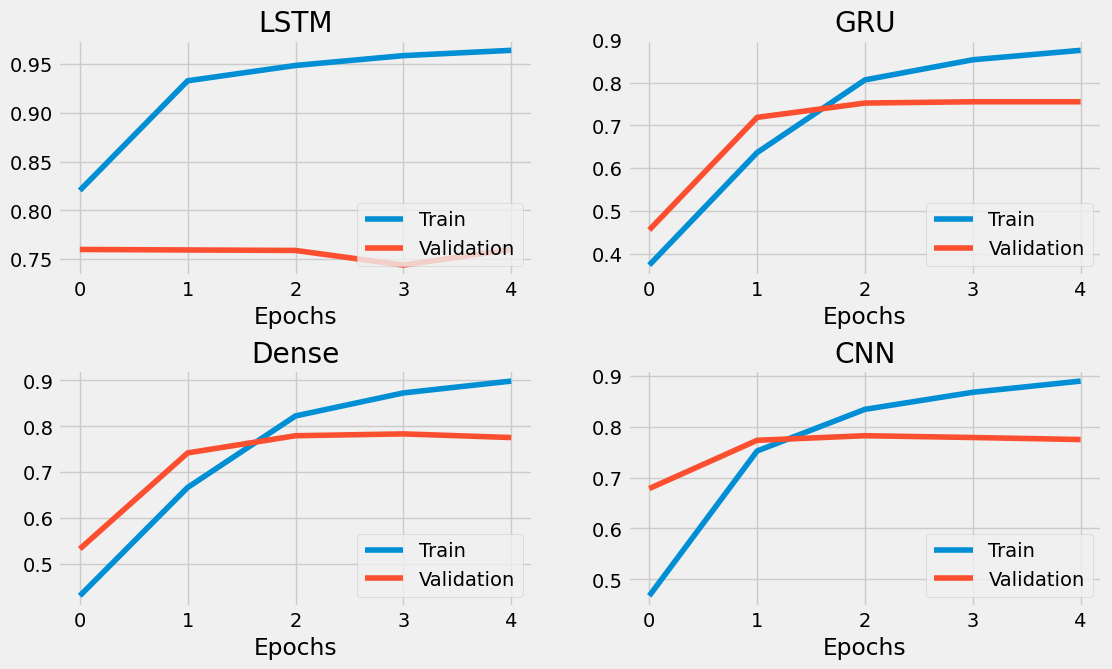

In [55]:
plt.subplots(figsize=(12, 7))
plt.subplots_adjust(hspace=0.4)

plt.subplot(2, 2, 1)

plt.plot(model1_history.history['accuracy'], label='Train')
plt.plot(model1_history.history['val_accuracy'], label='Validation')
plt.legend(loc='lower right')
plt.title('LSTM')
plt.xlabel('Epochs')

plt.subplot(2, 2, 2)

plt.plot(model2_history.history['accuracy'], label='Train')
plt.plot(model2_history.history['val_accuracy'], label='Validation')
plt.legend(loc='lower right')
plt.title('GRU')
plt.xlabel('Epochs')

plt.subplot(2, 2, 3)

plt.plot(model3_history.history['accuracy'], label='Train')
plt.plot(model3_history.history['val_accuracy'], label='Validation')
plt.legend(loc='lower right')
plt.title('Dense')
plt.xlabel('Epochs')

plt.subplot(2, 2, 4)

plt.plot(model4_history.history['accuracy'], label='Train')
plt.plot(model4_history.history['val_accuracy'], label='Validation')
plt.legend(loc='lower right')
plt.title('CNN')
plt.xlabel('Epochs')

plt.show()

In [59]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                        